In [470]:
import json 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy as cp
from scipy.special import softmax

#### FUNCTIONS

In [786]:
def map_load(path):
    with open(path, 'r') as f:
        data = json.load(f)
    nodes = {}
    links = {}
    for n in data.get("nodes"):
        nodes[n.get("ID")] = n
    for l in data.get("links"):
        links[l.get("SOURCE"), l.get("TARGET")] = 1
    nodes_dict = {key:(nodes[key]["X"], nodes[key]["Y"]) for key in nodes.keys()}
    node_list = list(nodes_dict.values())
    link_list = [(nodes_dict[n[0]], nodes_dict[n[1]]) for n in links.keys()]
    
    g = nx.Graph()
    g.add_nodes_from(node_list)
    g.add_edges_from(link_list)
    
    col = {nodes_dict[i]:r["reward"] for i,r in enumerate(nodes.values())}
    
    nx.set_node_attributes(g, col, "reward")
    return g
    
def measureOnGraph(g, measure):
    if measure == "BETWEENNESS":
        return nx.betweenness_centrality(g)
    elif measure == "CLOSENESS":
        return nx.closeness_centrality(g)
    elif measure == "DEGREE":
        return nx.degree_centrality(g)
    elif measure == "EIGENVECTOR":
        return nx.eigenvector_centrality(g, max_iter=1000)
    else: 
        return "Error: measure not found"
    
def pathIntegralMeasure(path, measure):
    return np.sum([measure[node] for node in path])

#Given a string identift the characters that are preceeded and follow by ann underscore
def extract_numbers(string):
    numbers = []
    for substr in string.split('_'):
        try:
            num = int(substr)
            numbers.append(num)
        except ValueError:
            pass
    return numbers

#Let's make a function that takes as input a astring and returnns the nnumber betweenn char S and char R
def extract_start(string):
    start = string.find('S')
    end = string.find('R')
    return int(string[start+1:end])

#Let's make a function that takes as input a list of lists and returns the intersection of all the lists
def intersection(lsts):
    sharedItems = set(lsts[0])
    for lst in lsts[1:]:
        sharedItems.intersection_update(lst)
    return list(sharedItems)
    
def plot_bars(data, title):
    fig, ax = plt.subplots()
    y_pos = range(len(data))
    min_value = min(data.values())
    colors = ['green' if v == min_value else 'grey' for v in data.values()]
    ax.barh(y_pos, data.values(), align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data.keys())
    ax.invert_yaxis()
    ax.set_xlabel('Value')
    ax.set_title(title+ 'mean values')
    plt.show()
    
#Relevant Goal Information
def get_RGI(G,beta=10.,n_steps=50,diagonal_actions=False,distances=None):
    
    n_states = len(G)
    
    coord2ind = {(x,y):node for node,(x,y) in G.pos.items()}
        
    up = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[0,1])))
    up_right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,1])))
    right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,0])))
    down_right = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[1,-1])))
    down = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[0,-1])))
    down_left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,-1])))
    left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,0])))
    up_left = lambda node : coord2ind.get(tuple(list(np.array(G.pos[node])+[-1,1])))
        
        

    if diagonal_actions:
        actions = [up,up_right,right,down_right,down,down_left,left,up_left]
    else:
        actions = [up,right,down,left]
    n_actions = len(actions)
    
    if distances is None:
        #generate Q
        distances = {node:{} for node in G.nodes}
        for node1 in G.nodes:
            d = nx.algorithms.shortest_path_length(G,node1)
            for node2 in G.nodes:
                distances[node1][node2] = d[node2]
                distances[node2][node1] = d[node2]
    
    Q = np.zeros((n_states,n_states,n_actions))
    node2i = {node:i for i,node in enumerate(list(G.nodes))}
    for n1 in G.nodes:
        for goal in G.nodes:
            scores = []
            scores_index = []
            for i,a in enumerate(actions):
                n2 = a(n1)
                if n2 in list(G[n1]):
                    scores.append(-distances[goal][n2])
                    scores_index.append(i)
            scores = softmax(10.*np.array(scores))

            for s,s_i in zip(scores,scores_index):
                Q[node2i[goal],node2i[n1],s_i] = s
    
    
    #generate uniform p_a_s
    p_a_s = np.where(Q.mean(axis=0)>0., 1.,0.)
    p_a_s = p_a_s / p_a_s.sum(axis=1).reshape((p_a_s.shape[0],1))


    history_pasg = []
    for _ in range(n_steps):
        #generate p_a_s_g
        p_a_s_g = np.array([p_a_s for _ in range(n_states)])*np.exp(beta*Q)
        temp = p_a_s_g.sum(axis=2)
        Z = np.stack((temp,temp,temp,temp),axis=2)

        p_a_s_g = p_a_s_g / Z
        history_pasg.append(np.abs(p_a_s_g))

        #generate p_a_s
        p_a_s = p_a_s_g.mean(axis=0)
    history_pasg = np.array(history_pasg)
        
    p_a_s += 10**-200
    I1 = p_a_s * np.log(p_a_s)
    I1 = I1.sum(axis=-1)
    
    p_a_s_g += 10**-200
    I2 = p_a_s_g * np.log(p_a_s_g)
    I2 = I2.mean(axis=0).sum(axis=-1)
    
    I = -I1 + I2
    
    return I, history_pasg

In [19]:
maps_path = "/Users/Mattia/Desktop/OngoingProjects/ThinkAheadBACKUP/ANALISI_THINK_AHEAD/SYNOPSIS/FILE_UTILI_INPUT/MAPS"
IMPORT_I_PATH = "./IMPORT_I/"

In [20]:
#Import the file MapSolution.json that conntains the solution of the 90 problems of the ThinkAhead competition
with open(IMPORT_I_PATH + "MapSolution.json") as f:
    data = json.load(f)
maps = list(data.keys())
FullSpectrumSolutions = cp.deepcopy(data)

In [21]:
#Import the json file mongo_data_17_02_2022.json
with open(IMPORT_I_PATH + "mongo_data_17_02_2022.json") as f:
    DATA = json.load(f)
#Each key of DATA represents a subject
HumanSolutions = {map:[] for map in maps}
for subj in range(len(DATA)):
    for map in DATA[subj]["trialData"].keys():
        if (map + ".json" in maps) and (DATA[subj]["trialData"][map]["Successful"]) and (DATA[subj]["trialData"][map]["FinalNodePath"] in FullSpectrumSolutions[map + ".json"]):
            HumanSolutions[map + ".json"].append(DATA[subj]["trialData"][map]["FinalNodePath"])
#Remore all the None values
for map in HumanSolutions.keys():
    HumanSolutions[map] = [sol for sol in HumanSolutions[map] if sol != None]
#Save the human solutions in a json file
with open(IMPORT_I_PATH + "HumanSolutions.json", "w") as f:
    json.dump(HumanSolutions, f)

In [22]:
#Shortest path solutions
ShortestPathSolutions = {}
for map in FullSpectrumSolutions.keys():
    ShortestPathSolutions[map] = [sol for sol in FullSpectrumSolutions[map] if len(sol) == min([len(solution) for solution in FullSpectrumSolutions[map]])]
#Save the shortest path solutions in a json file
with open(IMPORT_I_PATH + "ShortestPathSolutions.json", "w") as f:
    json.dump(ShortestPathSolutions, f)

In [23]:
#For each map compute the frequency of the lenghts of the solutions in HumanSolutions
LengthsFrequency = {}
for map in HumanSolutions.keys():
    LengthsFrequency[map] = {}
    NORM = 0
    for sol in HumanSolutions[map]:
        if len(sol) in LengthsFrequency[map].keys():
            LengthsFrequency[map][len(sol)] += 1
        else:
            LengthsFrequency[map][len(sol)] = 1
        NORM += 1
        #Normalize the frequency
    LengthsFrequency[map] = {key:val/NORM for key,val in LengthsFrequency[map].items()}
#Save the LengthsFrequency in a json file
with open(IMPORT_I_PATH + "LengthsFrequency.json", "w") as f:
    json.dump(LengthsFrequency, f)

#Let's get the AvailableLengths
AvailableLengths = {}
for map in LengthsFrequency.keys():
    AvailableLengths[map] = list(LengthsFrequency[map].keys())
#Save the AvailableLengths in a json file
with open(IMPORT_I_PATH + "AvailableLengths.json", "w") as f:
    json.dump(AvailableLengths, f)

#For each key in FullSpectrumSolutions let's compute the length of the solution and if it is in AvailableLengths let's keep it
PartialSpectrumSolutions = {}
for map in FullSpectrumSolutions.keys():
    for i,sol in enumerate(FullSpectrumSolutions[map]):
        if len(sol) in AvailableLengths[map]:
            if map in PartialSpectrumSolutions.keys():
                PartialSpectrumSolutions[map].append(sol)
            else:
                PartialSpectrumSolutions[map] = [sol]
#Save the PartialSpectrumSolutions in a json file
with open(IMPORT_I_PATH + "PartialSpectrumSolutions.json", "w") as f:
    json.dump(PartialSpectrumSolutions, f)
                
#For each map let's also count the number of solutions with the same length
Normalizations = {}
for map in PartialSpectrumSolutions.keys():
    Normalizations[map] = {}
    for sol in PartialSpectrumSolutions[map]:
        if len(sol) in Normalizations[map].keys():
            Normalizations[map][len(sol)] += 1
        else:
            Normalizations[map][len(sol)] = 1
#Save the Normalizations in a json file
with open(IMPORT_I_PATH + "Normalizations.json", "w") as f:
    json.dump(Normalizations, f)

#Assign a probabiilty to each agent solution
Probabilities = {}
for map in PartialSpectrumSolutions.keys():
    Probabilities[map] = {}
    for solIndex, sol in enumerate(PartialSpectrumSolutions[map]):
        Probabilities[map][solIndex] = LengthsFrequency[map][len(sol)]/Normalizations[map][len(sol)]
#Save the Probabilities in a json file
with open(IMPORT_I_PATH + "Probabilities.json", "w") as f:
    json.dump(Probabilities, f)


#### IMPORTS I

In [52]:
#Let's import human solutions
with open(IMPORT_I_PATH + "HumanSolutions.json") as f:
    HumanSolutions = json.load(f)
#Let's import the shortest path solutions
with open(IMPORT_I_PATH + "ShortestPathSolutions.json") as f:
    ShortestPathSolutions = json.load(f)
#Let's import the Full spectrum solutions
with open(IMPORT_I_PATH + "MapSolution.json") as f:
    FullSpectrumSolutions = json.load(f)
#Let's import the partial spectrum solutions
with open(IMPORT_I_PATH + "PartialSpectrumSolutions.json") as f:
    PartialSpectrumSolutions = json.load(f)
#Let's import the probabilities and convert the keys to int
with open(IMPORT_I_PATH + "Probabilities.json") as f:
    Probabilities = json.load(f)
Probabilities = {map:{int(key):val for key,val in Probabilities[map].items()} for map in Probabilities.keys()}
#Let's import the available lengths
with open(IMPORT_I_PATH + "AvailableLengths.json") as f:
    AvailableLengths = json.load(f)
#Let's import the lengths frequency and convert the keys to int
with open(IMPORT_I_PATH + "LengthsFrequency.json") as f:
    LengthsFrequency = json.load(f)
LengthsFrequency = {map:{int(key):val for key,val in LengthsFrequency[map].items()} for map in LengthsFrequency.keys()}
#Let's import the normalizations and convert the keys to int
with open(IMPORT_I_PATH + "Normalizations.json") as f:
    Normalizations = json.load(f)
Normalizations = {map:{int(key):val for key,val in Normalizations[map].items()} for map in Normalizations.keys()}


#### MEASURE

In [97]:
misura = "EIGENVECTOR"
#Create a directory to save the results with the name of the measure
if not os.path.exists("./" + misura):
    os.makedirs("./" + misura)

#### FULL SPECTRUM

In [100]:
#For each key in data dictionary let's load the map
integralMeasureFullSpectrum  ={}
for map in data.keys():
    #Compute the nodes betweenness centrality of the map
    g = map_load(os.path.join(maps_path, map))
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    measure = measureOnGraph(g, misura)
    #Compute the integral of the measure on the full spectrum
    integralMeasureFullSpectrum[map] = [pathIntegralMeasure([node_id_to_coord[n] for n in sol], measure) for sol in FullSpectrumSolutions[map]]   
#For each map let's compute the mean and the standard deviation of the integral measure
meanIntegralMeasureFullSpectrum = {map:np.mean(integralMeasureFullSpectrum[map]) for map in integralMeasureFullSpectrum.keys()}
stdIntegralMeasureFullSpectrum = {map:np.std(integralMeasureFullSpectrum[map]) for map in integralMeasureFullSpectrum.keys()}
semIntegralMeasureFullSpectrum = {map:np.std(integralMeasureFullSpectrum[map])/np.sqrt(len(integralMeasureFullSpectrum[map])) for map in integralMeasureFullSpectrum.keys()}
#Save the result in a json file
with open("./" + misura + "/integral"+ misura + "FullSpectrum.json", "w") as f:
    json.dump(integralMeasureFullSpectrum, f)
#Save the result in a json file
with open("./" + misura + "/meanIntegral" + misura+ "FullSpectrum.json", "w") as f:
    json.dump(meanIntegralMeasureFullSpectrum, f)
#Save the result in a json file
with open("./" + misura + "/stdIntegral" + misura + "FullSpectrum.json", "w") as f:
    json.dump(stdIntegralMeasureFullSpectrum, f)
#Save the result in a json file
with open("./" + misura + "/semIntegral" + misura + "FullSpectrum.json", "w") as f:
    json.dump(semIntegralMeasureFullSpectrum, f)

### HUMANS

In [101]:
#Let's now compute the integral betweenness of the human solutions
integralMeasureHuman = {}
for map in HumanSolutions.keys():
    #Compute the nodes betweenness centrality of the map
    g = map_load(os.path.join(maps_path, map))
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    measure = measureOnGraph(g, misura)
    #Compute the summed beetwenness of the solutions
    integralMeasureHuman[map] = [pathIntegralMeasure([node_id_to_coord[n] for n in sol], measure) for sol in HumanSolutions[map]]
#For each map let's compute the mean and the standard deviation of the integral measure
meanIntegralMeasureHuman = {map:np.mean(integralMeasureHuman[map]) for map in integralMeasureHuman.keys()}
stdIntegralMeasureHuman = {map:np.std(integralMeasureHuman[map]) for map in integralMeasureHuman.keys()}
semIntegralMeasureHuman = {map:np.std(integralMeasureHuman[map])/np.sqrt(len(integralMeasureHuman[map])) for map in integralMeasureHuman.keys()}
#Save the result in a json file
with open("./" + misura + "/integral" + misura + "Human.json", "w") as f:
    json.dump(integralMeasureHuman, f)
#Save the result in a json file
with open("./" + misura + "/meanIntegral" + misura + "Human.json", "w") as f:
    json.dump(meanIntegralMeasureHuman, f)
#Save the result in a json file
with open("./" + misura + "/stdIntegral" + misura + "Human.json", "w") as f:
    json.dump(stdIntegralMeasureHuman, f)
#Save the result in a json file
with open("./" + misura + "/semIntegral" + misura + "Human.json", "w") as f:
    json.dump(semIntegralMeasureHuman, f)

#### PARTIAL SPECTRUM

In [102]:
#Let's now compute the integral betweenness of the Agent solutions
integralMeasurePartialSpectrum = {}
for map in PartialSpectrumSolutions.keys():
    #Compute the nodes betweenness centrality of the map
    g = map_load(os.path.join(maps_path, map))
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    measure = measureOnGraph(g, misura)
    #Compute the weighted mean beetwenness of the solutions (the weight is the frequency of the length of the solution)
    integralMeasurePartialSpectrum[map] = []
    for sol in PartialSpectrumSolutions[map]:
        measureSol = pathIntegralMeasure([node_id_to_coord[n] for n in sol], measure)
        integralMeasurePartialSpectrum[map].append(measureSol)
    lenghts = [len(sol) for sol in PartialSpectrumSolutions[map]]
    #Let's sum the integral betweenness of the solutions with the same length  and average them
    integralMeasurePartialSpectrum[map] = {lenght:np.mean([integralMeasurePartialSpectrum[map][i] for i,l in enumerate(lenghts) if l == lenght]) for lenght in set(lenghts)}
    #Let's now compute the weighted mean of the integral betweenness
    integralMeasurePartialSpectrum[map] = np.sum([integralMeasurePartialSpectrum[map][lenght]*LengthsFrequency[map][lenght] for lenght in integralMeasurePartialSpectrum[map].keys()])
    #Let's now normalize the integral betweenness
    integralMeasurePartialSpectrum[map] /= np.sum([LengthsFrequency[map][lenght] for lenght in LengthsFrequency[map].keys()])
#For each map let's compute the mean and the standard deviation of the integral measure
meanIntegralMeasurePartialSpectrum = {map:np.mean(integralMeasurePartialSpectrum[map]) for map in integralMeasurePartialSpectrum.keys()}
#Save the result in a json file
with open("./" + misura + "/integral" + misura + "PartialSpectrum.json", "w") as f:
    json.dump(integralMeasurePartialSpectrum, f)
#Save the result in a json file
with open("./" + misura + "/meanIntegral" + misura + "PartialSpectrum.json", "w") as f:
    json.dump(meanIntegralMeasurePartialSpectrum, f)


In [104]:
#Let's compute the standard deviation of the integral betweenness of the algorithm solutions by simulating a sampling of the solutions according to the frequency of the lenghts
stdIntegralMeasurePartialSpectrum = {}
semIntegralMeasurePartialSpectrum = {}
for map in integralMeasurePartialSpectrum.keys():
    integralMeasurePartialSpectrumSampled = []
    #Compute the nodes betweenness centrality of the map
    g = map_load(os.path.join(maps_path, map))
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    measure = measureOnGraph(g, misura)
    for i in range(len(HumanSolutions[map])):
        #Let's sample the solutions according to Probabilities
        sampledSolutions = [PartialSpectrumSolutions[map][solI] for solI in np.random.choice(list(Probabilities[map].keys()), size=len(HumanSolutions[map]), p=list(Probabilities[map].values()))]
        #Let's compute the integral betweenness of the sampled solutions
        integralBetweennessAgentSampled = []
        for solIndex, sol in enumerate(sampledSolutions):
            measureSol = pathIntegralMeasure([node_id_to_coord[n] for n in sol], measure)
            integralBetweennessAgentSampled.append(measureSol)
    #LEt's compute the standard error of the mean
    stdIntegralMeasurePartialSpectrum[map] = np.std(integralBetweennessAgentSampled, axis=0)
    semIntegralMeasurePartialSpectrum[map] = stdIntegralMeasurePartialSpectrum[map]/np.sqrt(len(HumanSolutions[map]))
#Save the result in a json file
with open("./" + misura + "/stdIntegral" + misura + "PartialSpectrum.json", "w") as f:
    json.dump(stdIntegralMeasurePartialSpectrum, f)
#Save the result in a json file
with open("./" + misura + "/semIntegral" + misura + "PartialSpectrum.json", "w") as f:
    json.dump(semIntegralMeasurePartialSpectrum, f)

#### SHORTEST PATH SOLUTIONS

In [105]:
#Let's now compute the shortest path betweenness of the full solutions
integralMeasureShortestPath = {}
for map in PartialSpectrumSolutions.keys():
    #Compute the nodes betweenness centrality of the map
    g = map_load(os.path.join(maps_path, map))
    #Dictionary to pass from node id to node coordinates
    node_id_to_coord = {i:node for i,node in enumerate(g.nodes)}
    measure = measureOnGraph(g, misura)
    for sol in ShortestPathSolutions[map]:
        measureSol = pathIntegralMeasure([node_id_to_coord[n] for n in sol], measure)
        if map in integralMeasureShortestPath.keys():
            integralMeasureShortestPath[map].append(measureSol)
        else:
            integralMeasureShortestPath[map] = [measureSol]
#stats
meanIntegralMeasureShortestPath = {}
stdIntegralMeasureShortestPath = {}
semIntegralMeasureShortestPath = {}
for map in integralMeasureShortestPath.keys():
    meanIntegralMeasureShortestPath[map] = np.mean(integralMeasureShortestPath[map])
    stdIntegralMeasureShortestPath[map] = np.std(integralMeasureShortestPath[map])
    semIntegralMeasureShortestPath[map] = stdIntegralMeasureShortestPath[map]/np.sqrt(len(integralMeasureShortestPath[map]))
#Save the result in a json file
with open("./" + misura + "/integral" + misura + "ShortestPath.json", "w") as f:
    json.dump(integralMeasureShortestPath, f)
#Save the result in a json file
with open("./" + misura + "/meanIntegral" + misura + "ShortestPath.json", "w") as f:
    json.dump(meanIntegralMeasureShortestPath, f)
#Save the result in a json file
with open("./" + misura + "/stdIntegral" + misura + "ShortestPath.json", "w") as f:
    json.dump(stdIntegralMeasureShortestPath, f)
#Save the result in a json file
with open("./" + misura + "/semIntegral" + misura + "ShortestPath.json", "w") as f:
    json.dump(semIntegralMeasureShortestPath, f)

#### MISURA

In [181]:
misura = "BETWEENNESS"

#### IMPORTS II

In [182]:
#Let's load the json files
#PARTIAL SPECTRUM
with open('./' + misura + '/integral' +misura +'PartialSpectrum.json') as f:
    integralMeasurePartialSpectrum = json.load(f)
with open('./' + misura + '/meanIntegral' +misura +'PartialSpectrum.json') as f:
    meanIntegralMeasurePartialSpectrum = json.load(f)
with open('./' + misura + '/stdIntegral' +misura +'PartialSpectrum.json') as f:
    stdIntegralMeasurePartialSpectrum = json.load(f)
with open('./' + misura + '/semIntegral' +misura +'PartialSpectrum.json') as f:
    semIntegralMeasurePartialSpectrum = json.load(f)
#SHORTEST PATH
with open('./' + misura + '/integral' +misura +'ShortestPath.json') as f:
    integralMeasureShortestPath = json.load(f)
with open('./' + misura + '/meanIntegral' +misura +'ShortestPath.json') as f:
    meanIntegralMeasureShortestPath = json.load(f)
with open('./' + misura + '/stdIntegral' +misura +'ShortestPath.json') as f:
    stdIntegralMeasureShortestPath = json.load(f)
with open('./' + misura + '/semIntegral' +misura +'ShortestPath.json') as f:
    semIntegralMeasureShortestPath = json.load(f)
#HUMANS
with open('./' + misura + '/integral' +misura +'Human.json') as f:
    integralMeasureHuman = json.load(f)
with open('./' + misura + '/meanIntegral' +misura +'Human.json') as f:
    meanIntegralMeasureHuman = json.load(f)
with open('./' + misura + '/stdIntegral' +misura +'Human.json') as f:
    stdIntegralMeasureHuman = json.load(f)
with open('./' + misura + '/semIntegral' +misura +'Human.json') as f:
    semIntegralMeasureHuman = json.load(f)
#FULL SPECTRUM
with open('./' + misura + '/integral' +misura +'FullSpectrum.json') as f:
    integralMeasureFullSpectrum = json.load(f)
with open('./' + misura + '/meanIntegral' +misura +'FullSpectrum.json') as f:
    meanIntegralMeasureFullSpectrum = json.load(f)
with open('./' + misura + '/stdIntegral' +misura +'FullSpectrum.json') as f:
    stdIntegralMeasureFullSpectrum = json.load(f)
with open('./' + misura + '/semIntegral' +misura +'FullSpectrum.json') as f:
    semIntegralMeasureFullSpectrum = json.load(f)

#### SORTING

In [183]:
#Let's sort list(meanIntegralMeasureHuman.values()) and find the corresponding indexes
sortedMeanIntegralMeasureHuman= sorted(list(meanIntegralMeasureHuman.values()), key=lambda x: x)
meanIntegralMeasureHumanSortedIndexes = [list(meanIntegralMeasureHuman.values()).index(x) for x in sortedMeanIntegralMeasureHuman]
sortedStdIntegralMeasureHuman = [list(stdIntegralMeasureHuman.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedSemIntegralMeasureHuman = [list(semIntegralMeasureHuman.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
#Let's sort the list(meanIntegralMeasurePartialSpectrum.values()) according to the indexes of the sorted list(meanIntegralMeasureHuman.values())
sortedMeanIntegralMeasurePartialSpectrum = [list(meanIntegralMeasurePartialSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedStdIntegralMeasurePartialSpectrum = [list(stdIntegralMeasurePartialSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedSemIntegralMeasurePartialSpectrum = [list(semIntegralMeasurePartialSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
#Let's sort the list(meanIntegralMeasureFullSpectrum.values()) according to the indexes of the sorted list(meanIntegralMeasureHuman.values())
sortedMeanIntegralMeasureFullSpectrum = [list(meanIntegralMeasureFullSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedStdIntegralMeasureFullSpectrum = [list(stdIntegralMeasureFullSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedSemIntegralMeasureFullSpectrum = [list(semIntegralMeasureFullSpectrum.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
#Let's sort the list(meanIntegralMeasureShortestPath.values()) according to the indexes of the sorted list(meanIntegralMeasureHuman.values())
sortedMeanIntegralMeasureShortestPath = [list(meanIntegralMeasureShortestPath.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedStdIntegralMeasureShortestPath = [list(stdIntegralMeasureShortestPath.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]
sortedSemIntegralMeasureShortestPath = [list(semIntegralMeasureShortestPath.values())[i] for i in meanIntegralMeasureHumanSortedIndexes]

#### PLOT

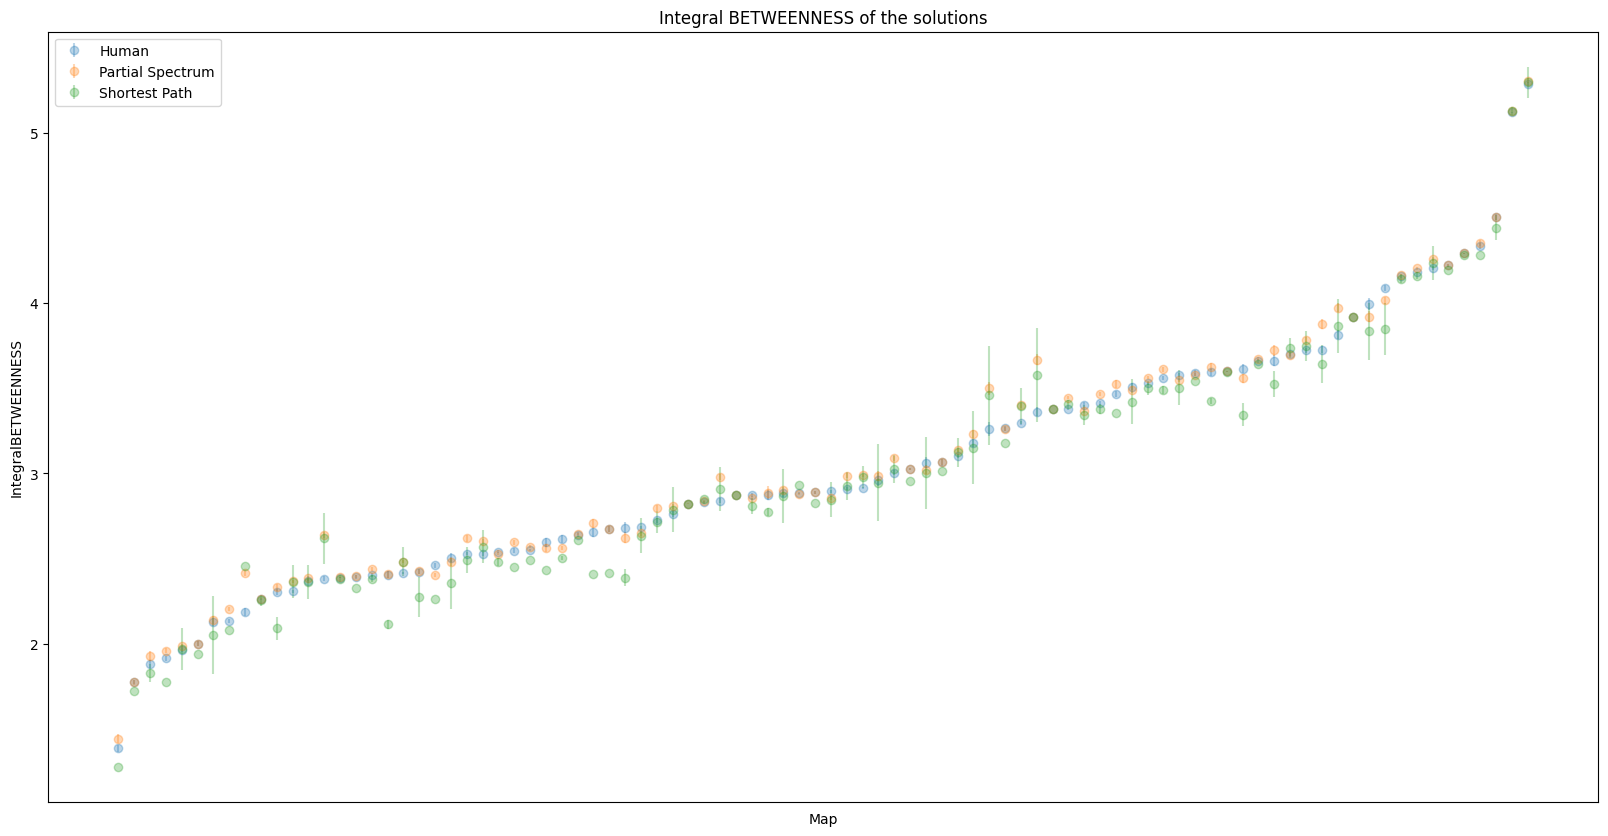

In [203]:
#Let's now plot the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(range(len(sortedMeanIntegralMeasureHuman)), sortedMeanIntegralMeasureHuman, yerr = sortedSemIntegralMeasureHuman, label='Human', fmt = "o", alpha = 0.3)
ax.errorbar(range(len(sortedMeanIntegralMeasurePartialSpectrum)), sortedMeanIntegralMeasurePartialSpectrum, yerr = sortedSemIntegralMeasurePartialSpectrum, label='Partial Spectrum', fmt = "o", alpha = 0.3)
#ax.errorbar(range(len(sortedMeanIntegralMeasureFullSpectrum)), sortedMeanIntegralMeasureFullSpectrum, yerr = sortedStdIntegralMeasureFullSpectrum, label='Full Spectrum', fmt = "o", alpha = 0.3)
ax.errorbar(range(len(sortedMeanIntegralMeasureShortestPath)), sortedMeanIntegralMeasureShortestPath, yerr = sortedStdIntegralMeasureShortestPath, label='Shortest Path', fmt = "o", alpha = 0.3)
ax.set_xlabel('Map')
ax.set_xticks([])
ax.set_ylabel('Integral' + misura)
ax.set_title('Integral ' + misura + ' of the solutions')
ax.legend()
plt.show()

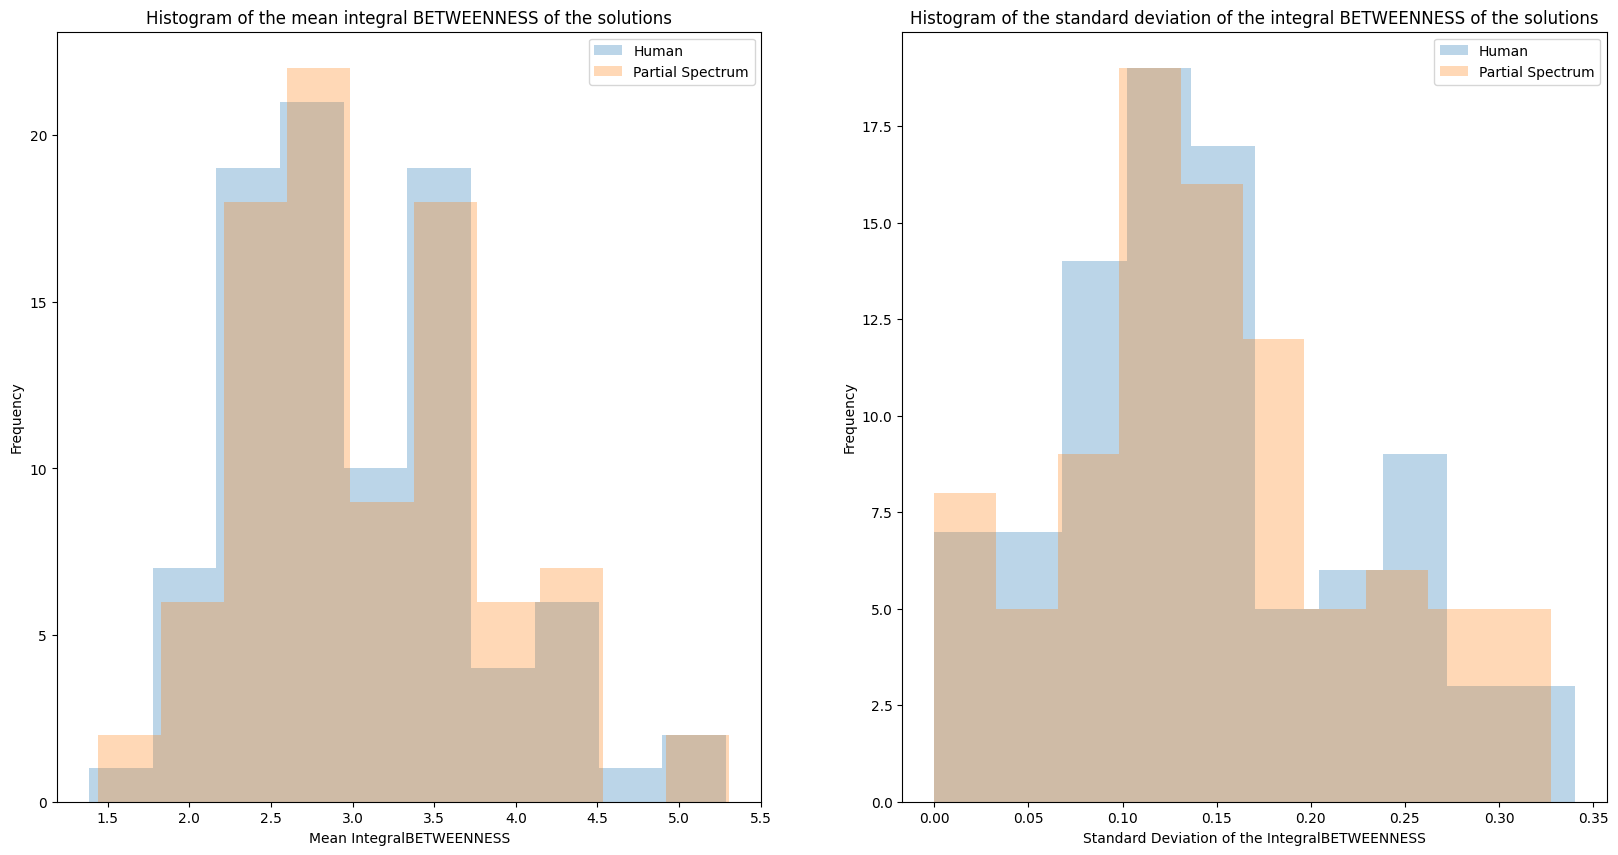

In [185]:
#Let's now make two plots, onne for the histograms of the mean integral measure and onn for the histograms of the standard deviation of the integral measure
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(list(meanIntegralMeasureHuman.values()), label='Human', alpha = 0.3)
ax[0].hist(list(meanIntegralMeasurePartialSpectrum.values()), label='Partial Spectrum', alpha = 0.3)
#ax[0].hist(list(meanIntegralMeasureFullSpectrum.values()), label='Full Spectrum', alpha = 0.3)
#ax[0].hist(list(meanIntegralMeasureShortestPath.values()), label='Shortest Path', alpha = 0.3)
ax[0].set_xlabel('Mean Integral' + misura)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of the mean integral ' + misura + ' of the solutions')
ax[0].legend()
ax[1].hist(list(stdIntegralMeasureHuman.values()), label='Human', alpha = 0.3)
ax[1].hist(list(stdIntegralMeasurePartialSpectrum.values()), label='Partial Spectrum', alpha = 0.3)
#ax[1].hist(list(stdIntegralMeasureFullSpectrum.values()), label='Full Spectrum', alpha = 0.3)
#ax[1].hist(list(stdIntegralMeasureShortestPath.values()), label='Shortest Path', alpha = 0.3)
ax[1].set_xlabel('Standard Deviation of the Integral' + misura)
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of the standard deviation of the integral ' + misura + ' of the solutions')
ax[1].legend()
plt.show()

#### STATISTICAL SIGNIFICANCE ANALYSIS

In [186]:
#Let's find the difference between the integral of the human and the integral of the partial spectrum
diffIntegralHumanPartialSpectrum = [sortedMeanIntegralMeasureHuman[i] - sortedMeanIntegralMeasurePartialSpectrum[i] for i in range(len(sortedMeanIntegralMeasureHuman))]
diffIntegralHumanFullSpectrum = [sortedMeanIntegralMeasureHuman[i] - sortedMeanIntegralMeasureFullSpectrum[i] for i in range(len(sortedMeanIntegralMeasureHuman))]

In [187]:
#Let's find the difference between the integral of the human and the integral of the partial spectrum considering only the maps  where the variance of the integral of the Full Spectrum is greater than 0
diffIntegralHumanPartialSpectrumMoreThanOneSolution = [diffIntegralHumanPartialSpectrum[i] for i in range(len(diffIntegralHumanPartialSpectrum)) if sortedStdIntegralMeasureFullSpectrum[i] > 0]
diffIntegralHumanFullSpectrumMoreThanOneSolution = [diffIntegralHumanFullSpectrum[i] for i in range(len(diffIntegralHumanFullSpectrum)) if sortedStdIntegralMeasureFullSpectrum[i] > 0]

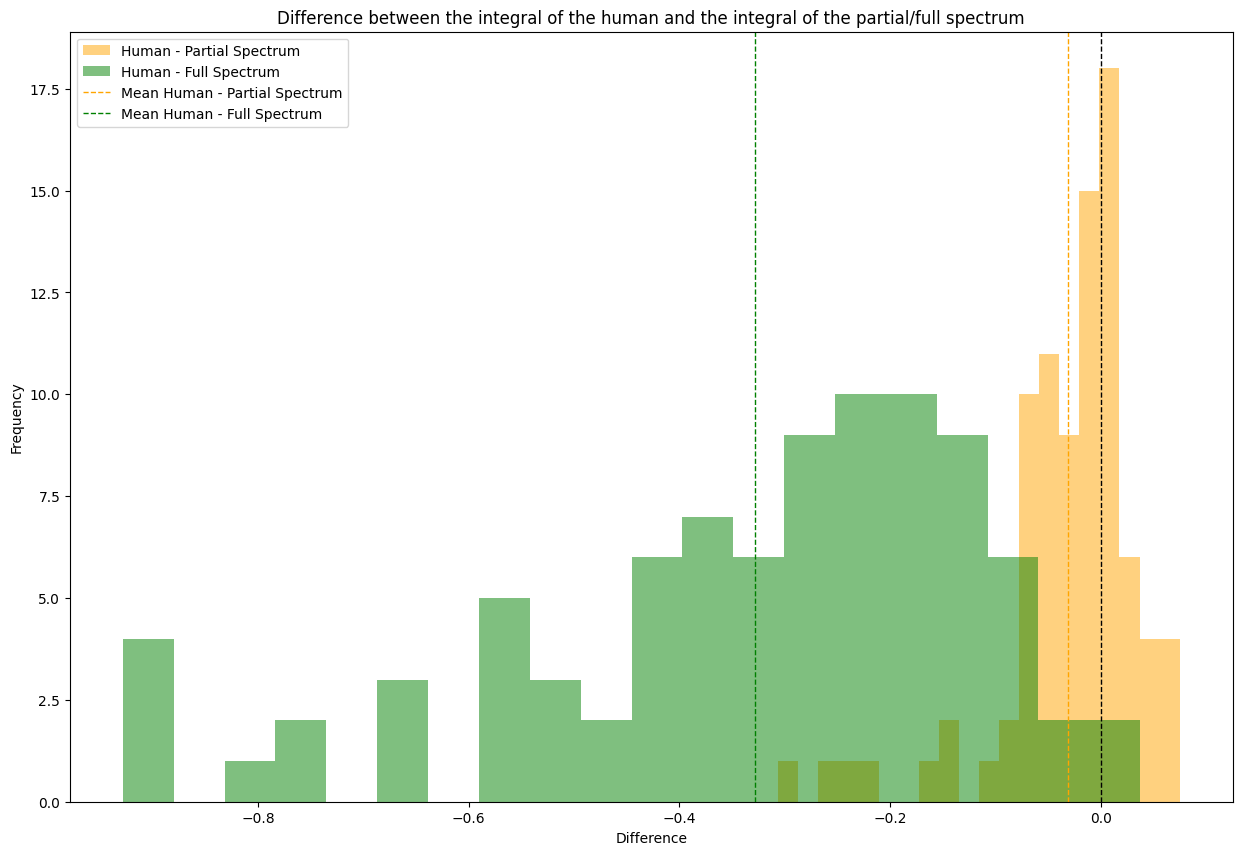

In [188]:
#And plot the histograms
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(diffIntegralHumanPartialSpectrumMoreThanOneSolution, bins = 20, label='Human - Partial Spectrum', alpha = 0.5, color = 'Orange')
ax.hist(diffIntegralHumanFullSpectrumMoreThanOneSolution, bins = 20, label='Human - Full Spectrum', alpha = 0.5, color = 'Green')
#vertical line for the mean
ax.axvline(np.mean(diffIntegralHumanPartialSpectrumMoreThanOneSolution), linestyle='dashed', linewidth=1, color='Orange', label='Mean Human - Partial Spectrum')
ax.axvline(np.mean(diffIntegralHumanFullSpectrumMoreThanOneSolution), linestyle='dashed', linewidth=1, color='Green', label='Mean Human - Full Spectrum')
#vertical line in 0
ax.axvline(0, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel('Difference')
ax.set_ylabel('Frequency')
ax.set_title('Difference between the integral of the human and the integral of the partial/full spectrum')
ax.legend()
plt.show()

#### Paired-t test

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# create example data
Y1 = np.array(sortedMeanIntegralMeasurePartialSpectrum)
Y2 = np.array(sortedMeanIntegralMeasureHuman)
differences = Y2 - Y1

# check for normality
plt.hist(differences)
plt.title("Histogram of Differences")
plt.show()

stats.probplot(differences, plot=plt)
plt.title("Q-Q Plot of Differences")
plt.show()

shapiro_test = stats.shapiro(differences)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

# check for homogeneity of variances
mean_differences = np.mean(differences)
plt.scatter(differences, differences)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Scatterplot of Differences")
plt.xlabel("Differences")
plt.ylabel("Differences")
plt.show()

levene_test = stats.levene(Y1, Y2)
print("Levene's test p-value:", levene_test.pvalue)

In [189]:
from scipy.stats import ttest_rel, wilcoxon

# perform paired-sample t-test
Y2 = sortedMeanIntegralMeasurePartialSpectrum
Y1 = sortedMeanIntegralMeasureHuman
t_statistic, p_value = ttest_rel(Y2, Y1)
print("Paired-sample t-test")
print("t statistic:", t_statistic)
print("p-value:", p_value)

Paired-sample t-test
t statistic: 4.321667275552538
p-value: 4.022293322418725e-05


Wilcoxon signed-rank test
z statistic: 936.0
p-value: 2.114099719100625e-05


#### Wilcoxon signed-rank test

In [192]:

import numpy as np
from scipy.stats import wilcoxon, norm, skew, ttest_rel

# Create some example data
X = Y1
Y = Y2

# Compute the differences
differences = Y - X

# Check the assumptions of the Wilcoxon signed-rank test

# 1. Independent observations
print("Are the observations independent?")
print("Yes, the paired observations are independent of each other.")

# 2. Paired differences are continuous or ordinal
print("Are the paired differences continuous or ordinal?")
print("Yes, the paired differences are continuous.")

# 3. Symmetric distribution
print("Is the distribution of the paired differences symmetric?")
print("To check this, we can plot a histogram and look at the skewness.")
print("Skewness:", skew(differences))
if abs(skew(differences)) < 1.96/np.sqrt(len(differences)):
    print("The distribution is approximately symmetric.")
else:
    print("The distribution may not be symmetric.")

# 4. Median difference is zero under the null hypothesis
print("Is the median of the differences zero under the null hypothesis?")
print("To check this, we can use a one-sample t-test.")
t_stat, p_value = ttest_rel(Y, X)
if p_value < 0.05:
    print("The median of the differences is not zero (p-value = %f)." % p_value)
else:
    print("The median of the differences is zero (p-value = %f)." % p_value)

# Perform the Wilcoxon signed-rank test
w_stat, p_value = wilcoxon(X, Y)
print("Wilcoxon signed-rank test:")
print("Statistic = %f, p-value = %f" % (w_stat, p_value))


Are the observations independent?
Yes, the paired observations are independent of each other.
Are the paired differences continuous or ordinal?
Yes, the paired differences are continuous.
Is the distribution of the paired differences symmetric?
To check this, we can plot a histogram and look at the skewness.
Skewness: -1.8180353065611001
The distribution may not be symmetric.
Is the median of the differences zero under the null hypothesis?
To check this, we can use a one-sample t-test.
The median of the differences is not zero (p-value = 0.000040).
Wilcoxon signed-rank test:
Statistic = 936.000000, p-value = 0.000021


In [193]:
# perform Wilcoxon signed-rank test
z_statistic, p_value = wilcoxon(np.array(Y2)-np.array(Y1))
print("Wilcoxon signed-rank test")
print("z statistic:", z_statistic)
print("p-value:", p_value)

Wilcoxon signed-rank test
z statistic: 936.0
p-value: 2.114099719100625e-05


#### Permutation test

In [194]:

# Define the paired data
x = Y1
y = Y2

# Calculate the observed difference
observed_diff = np.mean(x - y)

# Set the number of permutations
num_permutations = 1000

# Initialize an array to store the permutation differences
permutation_diffs = np.zeros(num_permutations)

# Loop over the permutations
for i in range(num_permutations):
    
    # Permute the differences
    permuted_diffs = np.random.permutation(x - y)
    
    # Calculate the difference between the permuted samples
    permutation_diffs[i] = np.mean(permuted_diffs)

# Calculate the p-value
p_value = np.mean(permutation_diffs >= observed_diff)

print("Observed difference:", observed_diff)
print("p-value:", p_value)


Observed difference: 0.03041098655924127
p-value: 1.0


### STATISTICAL SIGINFICANCE POINT TO POINT

In [473]:
#Let's run a gaussian test for the difference between the mean of the integral measure of the human and the mean of the integral measure of the partial/full spectrum
zScores = []
for i in range(len(sortedMeanIntegralMeasureHuman)):
    if sortedStdIntegralMeasurePartialSpectrum[i]>0:
        zScore =  (sortedMeanIntegralMeasurePartialSpectrum[i]-sortedMeanIntegralMeasureHuman[i])/np.sqrt((sortedStdIntegralMeasurePartialSpectrum[i]**2)/len(sortedMeanIntegralMeasureHuman)+(sortedStdIntegralMeasureHuman[i]**2)/len(sortedMeanIntegralMeasureHuman))
        zScores.append(zScore)

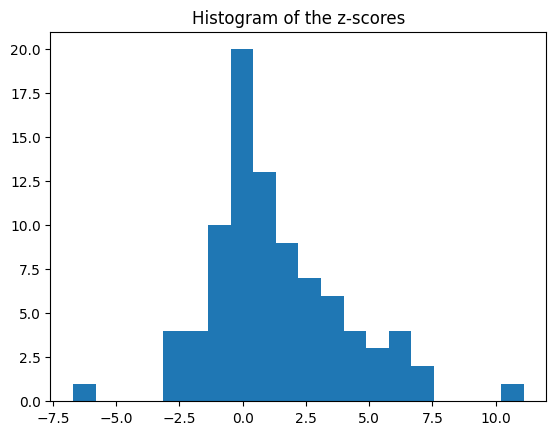

In [472]:
plt.hist(zScores, bins = 20)
plt.title('Histogram of the z-scores')
plt.show()

##### CORRELATION

In [255]:
#Let's compute the correlation between the nodeOccupancyHuman  and the measureCentrality for each map
correlationsHuman = []
for map in nodeOccupancyHuman.keys():
    correlationsHuman.append(np.corrcoef(nodeOccupancyHuman[map], measureCentrality[map])[0,1])
#Let's compute the correlation between the nodeOccupancyPartialSpectrum  and the measureCentrality for each map
correlationsPartialSpectrum = []
for map in nodeOccupancyPartialSpectrum.keys():
    correlationsPartialSpectrum.append(np.corrcoef(nodeOccupancyPartialSpectrum[map], measureCentrality[map])[0,1])
#Let's compute the correlation between the nodeOccupancyFullSpectrum  and the measureCentrality for each map
correlationsFullSpectrum = []
for map in nodeOccupancyFullSpectrum.keys():
    correlationsFullSpectrum.append(np.corrcoef(nodeOccupancyFullSpectrum[map], measureCentrality[map])[0,1])

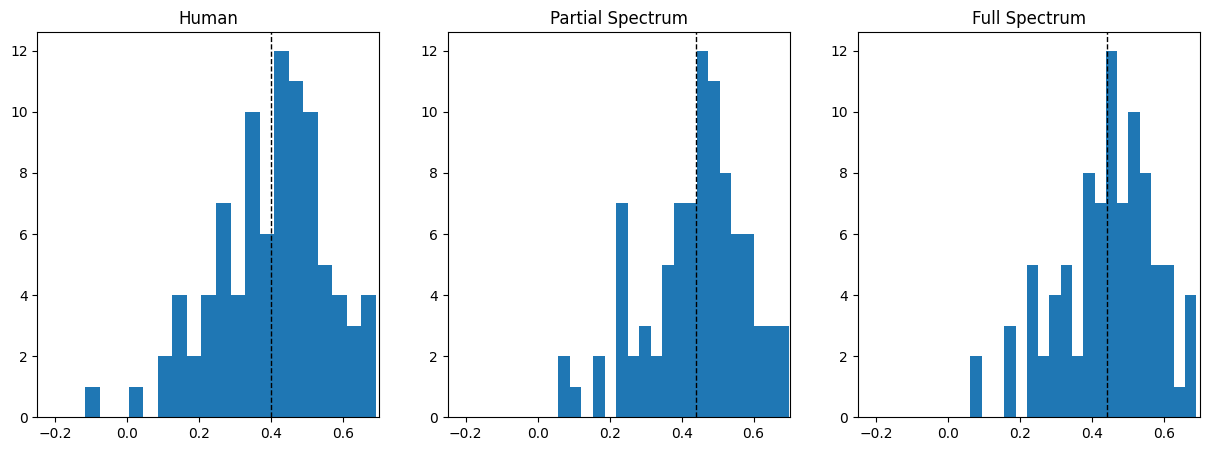

In [271]:
#Let's plot the hisogram of the three correlations in three different subplots with the same x axis range
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(correlationsHuman, bins = 20)
axs[0].set_title("Human")
axs[0].set_xlim(-.25,.7)
#mean
axs[0].axvline(np.mean(correlationsHuman), color='k', linestyle='dashed', linewidth=1)
axs[1].hist(correlationsPartialSpectrum, bins = 20)
axs[1].set_title("Partial Spectrum")
axs[1].set_xlim(-.25,.7)
#mean
axs[1].axvline(np.mean(correlationsPartialSpectrum), color='k', linestyle='dashed', linewidth=1)
axs[2].hist(correlationsFullSpectrum, bins = 20)
axs[2].set_title("Full Spectrum")
axs[2].set_xlim(-.25,.7)
#mean
axs[2].axvline(np.mean(correlationsFullSpectrum), color='k', linestyle='dashed', linewidth=1)
plt.show()


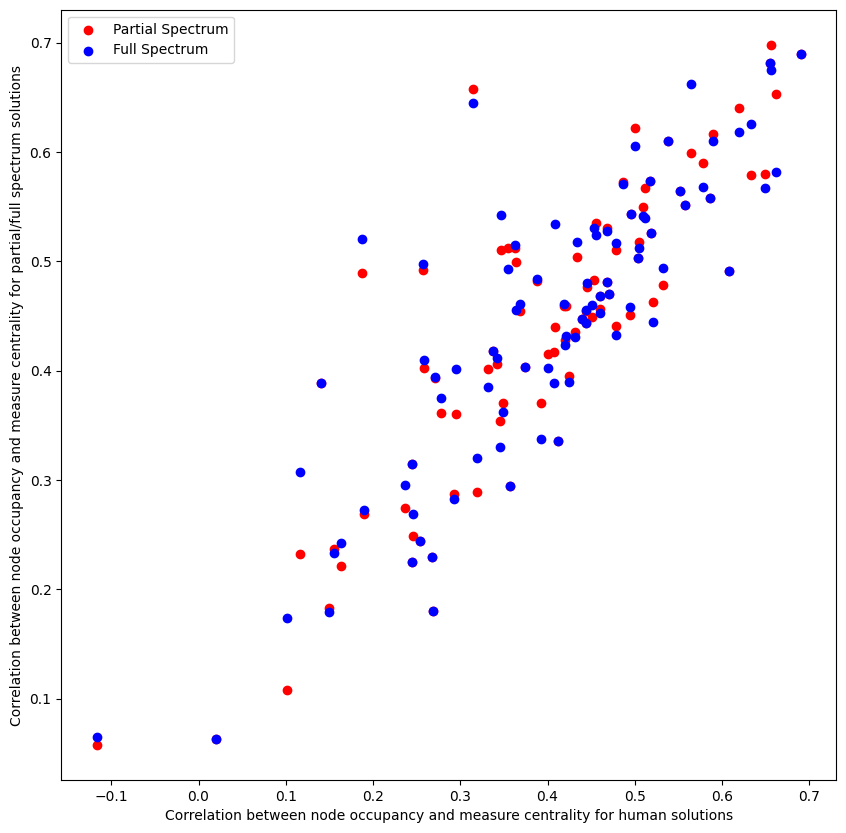

In [264]:
#LEt's plot the correlation between the node occupancy and the measure centrality for each map
plt.figure(figsize=(10,10))
plt.scatter(correlationsHuman, correlationsPartialSpectrum, color = "red", label = "Partial Spectrum")
plt.scatter(correlationsHuman, correlationsFullSpectrum, color = "blue", label = "Full Spectrum")
plt.xlabel("Correlation between node occupancy and measure centrality for human solutions")
plt.ylabel("Correlation between node occupancy and measure centrality for partial/full spectrum solutions")
plt.legend()
plt.show()
